<a href="https://colab.research.google.com/github/DayenaJeong/Spiking-DDPM/blob/master/FS_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

# Heaviside 함수 구현
def heaviside(x):
    return torch.where(x >= 0, torch.ones_like(x), torch.zeros_like(x))

# Let's correct the forward method to address the RuntimeError
# Ensure that dimensions are correctly handled when performing the operations

class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons
        # 입력 차원이 input_dim이고 출력 차원이 k_neurons인 가중치
        self.c = nn.Parameter(torch.randn(k_neurons, input_dim))
        # 각 뉴런의 출력에 곱해지는 추가 가중치
        self.d = nn.Parameter(torch.randn(k_neurons))
        # 뉴런 간 억제적 입력을 위한 가중치
        self.h = nn.Parameter(torch.zeros(k_neurons, k_neurons))
        # 각 뉴런의 활성화를 위한 임계값
        self.T = nn.Parameter(torch.randn(k_neurons))

    def forward(self, x):
        # batch_size를 x의 첫 번째 차원으로 사용
        batch_size = x.size(0)
        # 모든 뉴런의 출력을 저장하기 위한 텐서 초기화
        z = torch.zeros(batch_size, self.k_neurons, device=x.device)
        H = torch.zeros_like(z)
        for i in range(self.k_neurons):
            if i > 0:
                # 억제적 입력 계산
                H[:, i] = torch.sum(self.h[i, :i] * z[:, :i], dim=1)
            # 가중치, 억제적 입력, 임계값을 적용하고 Heaviside 함수를 통해 뉴런의 출력 계산
            z[:, i] = heaviside(torch.matmul(x, self.c[i].unsqueeze(-1)).squeeze(-1) - H[:, i] - self.T[i])
        # 최종 출력 계산
        y = torch.matmul(z, self.d)
        return y

# Heaviside step function
def heaviside(x):
    return torch.where(x >= 0, torch.ones_like(x), torch.zeros_like(x))

# Swish function definition
def swish_function(x):
    return x * torch.sigmoid(x)

# Instantiate the model
model = AMOSUnit(input_dim=1, k_neurons=12)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-5, 5, steps=100).unsqueeze(1)  # Inputs
y_train = swish_function(x_train)  # Targets (true Swish function values)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred.squeeze(), y_train.squeeze())  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 1.899073839187622
Epoch 101/10000, Loss: 0.898219883441925
Epoch 201/10000, Loss: 0.7256009578704834
Epoch 301/10000, Loss: 0.6322352290153503
Epoch 401/10000, Loss: 0.574015736579895
Epoch 501/10000, Loss: 0.5330303311347961
Epoch 601/10000, Loss: 0.5016653537750244
Epoch 701/10000, Loss: 0.476433664560318
Epoch 801/10000, Loss: 0.4555529057979584
Epoch 901/10000, Loss: 0.43798503279685974
Epoch 1001/10000, Loss: 0.42304638028144836
Epoch 1101/10000, Loss: 0.4102437198162079
Epoch 1201/10000, Loss: 0.39919984340667725
Epoch 1301/10000, Loss: 0.3896166980266571
Epoch 1401/10000, Loss: 0.3812541961669922
Epoch 1501/10000, Loss: 0.37391698360443115
Epoch 1601/10000, Loss: 0.3674449622631073
Epoch 1701/10000, Loss: 0.36170634627342224
Epoch 1801/10000, Loss: 0.3565923571586609
Epoch 1901/10000, Loss: 0.35201266407966614
Epoch 2001/10000, Loss: 0.34789198637008667
Epoch 2101/10000, Loss: 0.344167560338974
Epoch 2201/10000, Loss: 0.3407869040966034
Epoch 2301/10000, Los

기존 AMOS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class SurrogateHeaviside(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # Heaviside 함수의 순전파: 입력이 0 이상이면 1, 그렇지 않으면 0
        return torch.where(input >= 0, torch.ones_like(input), torch.zeros_like(input))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # 삼각형 모양의 서로게이트 미분: 입력의 절대값이 1보다 작은 경우, 1 - 절대값을 기울기로 사용
        surrogate_grad = 1 - torch.abs(input)
        surrogate_grad = torch.where(surrogate_grad > 0, surrogate_grad, torch.zeros_like(input))
        return grad_input * surrogate_grad

def heaviside(x):
    return SurrogateHeaviside.apply(x)

class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons
        # 입력 차원이 input_dim이고 출력 차원이 k_neurons인 가중치
        self.c = nn.Parameter(torch.randn(k_neurons, input_dim))
        # 각 뉴런의 출력에 곱해지는 추가 가중치
        self.d = nn.Parameter(torch.randn(k_neurons))
        # 뉴런 간 inhibitory input을 위한 가중치
        self.h = nn.Parameter(torch.zeros(k_neurons, k_neurons))
        # 각 뉴런의 활성화를 위한 임계값
        self.T = nn.Parameter(torch.randn(k_neurons))

    def forward(self, x):
      # batch_size를 x의 첫 번째 차원으로 사용
      batch_size = x.size(0)
      # 모든 뉴런의 출력을 저장하기 위한 텐서 초기화
      z = torch.zeros(batch_size, self.k_neurons, device=x.device)
      H = torch.zeros_like(z)
      for i in range(self.k_neurons):
          hi = torch.matmul(x, self.c[i].unsqueeze(-1)).squeeze(-1) - self.T[i]
          if i > 0:
              H[:, i] = torch.sum(self.h[i, :i] * z[:, :i], dim=1)
              hi = hi - H[:, i]
          zi = heaviside(hi).unsqueeze(1)
          if i < self.k_neurons - 1:
              z = torch.cat((z[:, :i], zi, z[:, i + 1:]), dim=1)
          else:
              z = torch.cat((z[:, :i], zi), dim=1)
      # 최종 출력 계산
      y = torch.matmul(z, self.d)
      return y

# Swish 함수 정의
def swish_function(x):
    return x * torch.sigmoid(x)

# 모델 인스턴스화
model = AMOSUnit(input_dim=1, k_neurons=12)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 훈련 데이터
x_train = torch.linspace(-5, 5, steps=100).unsqueeze(1)  # 입력
y_train = swish_function(x_train)  # 목표값 (실제 Swish 함수 값)

torch.autograd.set_detect_anomaly(True)

# 훈련 루프
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # 그래디언트 초기화
    y_pred = model(x_train)  # 순전파
    loss = criterion(y_pred.squeeze(), y_train.squeeze())  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    # 100번마다 손실 출력
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# 최종 손실 출력
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 3.5457210540771484
Epoch 101/10000, Loss: 0.49270889163017273
Epoch 201/10000, Loss: 0.27436569333076477
Epoch 301/10000, Loss: 0.22975711524486542
Epoch 401/10000, Loss: 0.10912023484706879
Epoch 501/10000, Loss: 0.0872383713722229
Epoch 601/10000, Loss: 0.07592630386352539
Epoch 701/10000, Loss: 0.06937884539365768
Epoch 801/10000, Loss: 0.0656108409166336
Epoch 901/10000, Loss: 0.06055530160665512
Epoch 1001/10000, Loss: 0.06036193668842316
Epoch 1101/10000, Loss: 0.060331545770168304
Epoch 1201/10000, Loss: 0.05640874430537224
Epoch 1301/10000, Loss: 0.05277394875884056
Epoch 1401/10000, Loss: 0.050656408071517944
Epoch 1501/10000, Loss: 0.052447427064180374
Epoch 1601/10000, Loss: 0.05077753961086273
Epoch 1701/10000, Loss: 0.048306904733181
Epoch 1801/10000, Loss: 0.05002811551094055
Epoch 1901/10000, Loss: 0.04691142588853836
Epoch 2001/10000, Loss: 0.04652268812060356
Epoch 2101/10000, Loss: 0.04872450977563858
Epoch 2201/10000, Loss: 0.04766784608364105
Ep

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class SurrogateHeaviside(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # Heaviside 함수의 순전파: 입력이 0 이상이면 1, 그렇지 않으면 0
        return torch.where(input >= 0, torch.ones_like(input), torch.zeros_like(input))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # 삼각형 모양의 서로게이트 미분: 입력의 절대값이 1보다 작은 경우, 1 - 절대값을 기울기로 사용
        surrogate_grad = 1 - torch.abs(input)
        surrogate_grad = torch.where(surrogate_grad > 0, surrogate_grad, torch.zeros_like(input))
        return grad_input * surrogate_grad

def heaviside(x):
    return SurrogateHeaviside.apply(x)

class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons
        # 입력 차원이 input_dim이고 출력 차원이 k_neurons인 가중치
        self.c = nn.Parameter(torch.randn(k_neurons, input_dim))
        # 각 뉴런의 출력에 곱해지는 추가 가중치
        self.d = nn.Parameter(torch.randn(k_neurons))
        # 뉴런 간 inhibitory input을 위한 가중치
        self.h = nn.Parameter(torch.zeros(k_neurons, k_neurons))
        # 각 뉴런의 활성화를 위한 임계값
        self.T = nn.Parameter(torch.randn(k_neurons))

    def forward(self, x):
      # batch_size를 x의 첫 번째 차원으로 사용
      batch_size = x.size(0)
      # 모든 뉴런의 출력을 저장하기 위한 텐서 초기화
      z = torch.zeros(batch_size, self.k_neurons, device=x.device)
      H = torch.zeros_like(z)
      for i in range(self.k_neurons):
          hi = torch.matmul(x, self.c[i].unsqueeze(-1)).squeeze(-1) - self.T[i]
          if i > 0:
              H[:, i] = torch.sum(self.h[i, :i] * z[:, :i], dim=1)
              hi = hi - H[:, i]
          zi = heaviside(hi).unsqueeze(1)
          if i < self.k_neurons - 1:
              z = torch.cat((z[:, :i], zi, z[:, i + 1:]), dim=1)
          else:
              z = torch.cat((z[:, :i], zi), dim=1)
      # 최종 출력 계산
      y = torch.matmul(z, self.d)
      return y

# Swish 함수 정의
def swish_function(x):
    return x * torch.sigmoid(x)

# 모델 인스턴스화
model = AMOSUnit(input_dim=1, k_neurons=12)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
# L2 가중치 정규화를 위한 weight_decay 매개변수 추가
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# 훈련 데이터
x_train = torch.linspace(-5, 5, steps=100).unsqueeze(1)  # 입력
y_train = swish_function(x_train)  # 목표값 (실제 Swish 함수 값)

torch.autograd.set_detect_anomaly(True)

# 훈련 루프
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # 그래디언트 초기화
    y_pred = model(x_train)  # 순전파
    loss = criterion(y_pred.squeeze(), y_train.squeeze())  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    # 1000번마다 손실 출력
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# 최종 손실 출력
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 7.339244365692139
Epoch 101/10000, Loss: 0.26978716254234314
Epoch 201/10000, Loss: 0.13513383269309998
Epoch 301/10000, Loss: 0.10360755026340485
Epoch 401/10000, Loss: 0.08328201621770859
Epoch 501/10000, Loss: 0.07619189471006393
Epoch 601/10000, Loss: 0.07373405247926712
Epoch 701/10000, Loss: 0.06921437382698059
Epoch 801/10000, Loss: 0.06440124660730362
Epoch 901/10000, Loss: 0.05916617065668106
Epoch 1001/10000, Loss: 0.056428879499435425
Epoch 1101/10000, Loss: 0.05836905166506767
Epoch 1201/10000, Loss: 0.0566294863820076
Epoch 1301/10000, Loss: 0.05252423882484436
Epoch 1401/10000, Loss: 0.051041316241025925
Epoch 1501/10000, Loss: 0.049921054393053055
Epoch 1601/10000, Loss: 0.04862380400300026
Epoch 1701/10000, Loss: 0.05906135216355324
Epoch 1801/10000, Loss: 0.045148711651563644
Epoch 1901/10000, Loss: 0.05241776630282402
Epoch 2001/10000, Loss: 0.05745592713356018
Epoch 2101/10000, Loss: 0.05400367081165314
Epoch 2201/10000, Loss: 0.04458083957433700

#temporal coding with two spikes

파라미터

In [2]:
swish_h = [0.7844085, 1.7550646, 1.4212719, 1.9244663,
           1.4400164, 1.9249276, 1.6100428, 1.29061, 0.83985287,
           3.0827985, 0.43503317, 0.5155389, 0.3269445, 7.618048,
           -14.419675, 0]
swish_d = [0.40088242, 1.8856316, 1.4915457, 1.947229, 1.4717816, 1.9147849,
           1.6389303, 1.2934641, 0.8703124, 0.68460804, 0.44262582, 0.32832766,
           0.13907616, -0.26217145, 0.23736191, -0.14830568]
swish_T = [0.05946945, 1.6541206, 1.3066754, 1.3267198, 1.1000695, 1.2308974,
           1.1188028, 0.9472501, 0.5447531, 1.0236325, 0.11921431, -0.12855051,
           -0.44731247, -2.1383545, 1., -4.109145]

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# PyTorch의 사용자 정의 그래디언트를 위한 spike function 구현
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# PyTorch spike function 호출
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# AMOSUnit 클래스 정의
class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons, swish_h, swish_d, swish_T):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons

        # FS 파라미터 정의
        self.h = torch.tensor(swish_h, dtype=torch.float32, requires_grad=False)
        self.d = torch.tensor(swish_d, dtype=torch.float32, requires_grad=False)
        self.T = torch.tensor(swish_T, dtype=torch.float32, requires_grad=False)

        # 학습 가능한 매개변수 추가
        self.linear = nn.Linear(input_dim, k_neurons)

        # 최종 출력을 위한 추가 선형 레이어
        self.final_linear = nn.Linear(k_neurons, 1)

    def forward(self, x):
        # 선형 변환 적용
        v = self.linear(x)

        # FS 스파이크 신경망을 위한 임시 출력 초기화
        temp_out = torch.zeros_like(v)

        # FS 스파이크 신경망 구현
        for t in range(len(self.T)):
            v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        # 최종 출력을 위해 추가된 선형 레이어 적용
        out = self.final_linear(temp_out)

        return out

# 모델 인스턴스화
input_dim = 1
k_neurons = len(swish_h)  # swish_h 길이에 맞춰 k_neurons 설정
model = AMOSUnit(input_dim, k_neurons, swish_h, swish_d, swish_T)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 훈련 데이터
x_train = torch.linspace(-5, 5, steps=100).unsqueeze(1)  # 입력
y_train = swish_function(x_train)  # 목표값 (실제 Swish 함수 값)
y_train_expanded = y_train.expand(-1, y_pred.size(1))

torch.autograd.set_detect_anomaly(True)

# 훈련 루프
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # 그래디언트 초기화
    y_pred = model(x_train)  # 순전파
    loss = criterion(y_pred, y_train)  # `.squeeze()` 호출 제거
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    # 100번마다 손실 출력
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# 최종 손실 출력
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 0.9209557175636292
Epoch 101/10000, Loss: 0.012180916033685207
Epoch 201/10000, Loss: 0.005354675464332104
Epoch 301/10000, Loss: 0.004677177872508764
Epoch 401/10000, Loss: 0.004116988740861416
Epoch 501/10000, Loss: 0.0039554559625685215
Epoch 601/10000, Loss: 0.0038080501835793257
Epoch 701/10000, Loss: 0.003556183073669672
Epoch 801/10000, Loss: 0.003567581530660391
Epoch 901/10000, Loss: 0.0033951089717447758
Epoch 1001/10000, Loss: 0.003128973301500082
Epoch 1101/10000, Loss: 0.0028970856219530106
Epoch 1201/10000, Loss: 0.0027311621233820915
Epoch 1301/10000, Loss: 0.0028568070847541094
Epoch 1401/10000, Loss: 0.0023357474710792303
Epoch 1501/10000, Loss: 0.0022651050239801407
Epoch 1601/10000, Loss: 0.0022100580390542746
Epoch 1701/10000, Loss: 0.0018959051230922341
Epoch 1801/10000, Loss: 0.0018519312143325806
Epoch 1901/10000, Loss: 0.0019235293148085475
Epoch 2001/10000, Loss: 0.0019050175324082375
Epoch 2101/10000, Loss: 0.001859729876741767
Epoch 2201/

 inhibitory input (self.h) 요소를 제거한 모델


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        # dz_dv_scaled 계산 시, 분모가 0이 되는 것을 방지하기 위해 작은 상수 epsilon을 추가합니다.
        epsilon = 1e-6
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device)) + epsilon
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons, swish_h, swish_d, swish_T):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons
        self.h = torch.tensor(swish_h, dtype=torch.float32, requires_grad=False)
        self.d = torch.tensor(swish_d, dtype=torch.float32, requires_grad=False)
        self.T = torch.tensor(swish_T, dtype=torch.float32, requires_grad=False)
        self.linear = nn.Linear(input_dim, k_neurons)
        self.final_linear = nn.Linear(k_neurons, 1)

    def forward(self, x):
        x = self.linear(x)
        temp_out = torch.zeros_like(x)
        for t in range(len(self.T)):
            v_scaled = (x - self.T[t]) / (torch.abs(x) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
        out = self.final_linear(temp_out)
        return out

input_dim = 1
k_neurons = 16  # 예시에서는 k_neurons의 정확한 값이 명시되지 않았으므로 임의로 설정합니다.
model = AMOSUnit(input_dim, k_neurons, swish_h, swish_d, swish_T)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

x_train = torch.linspace(-5, 5, steps=100).unsqueeze(1)
y_train = swish_function(x_train)

torch.autograd.set_detect_anomaly(True)

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    # Gradient Clipping 적용 예시
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 30.357799530029297
Epoch 1001/10000, Loss: 0.028473444283008575
Epoch 2001/10000, Loss: 0.02265232801437378
Epoch 3001/10000, Loss: 0.01692468486726284
Epoch 4001/10000, Loss: 0.01682710461318493
Epoch 5001/10000, Loss: 0.014182737097144127
Epoch 6001/10000, Loss: 0.013611945323646069
Epoch 7001/10000, Loss: 0.01252617035061121
Epoch 8001/10000, Loss: 0.010943923145532608
Epoch 9001/10000, Loss: 0.010635729879140854
Final Loss: 0.01911202445626259


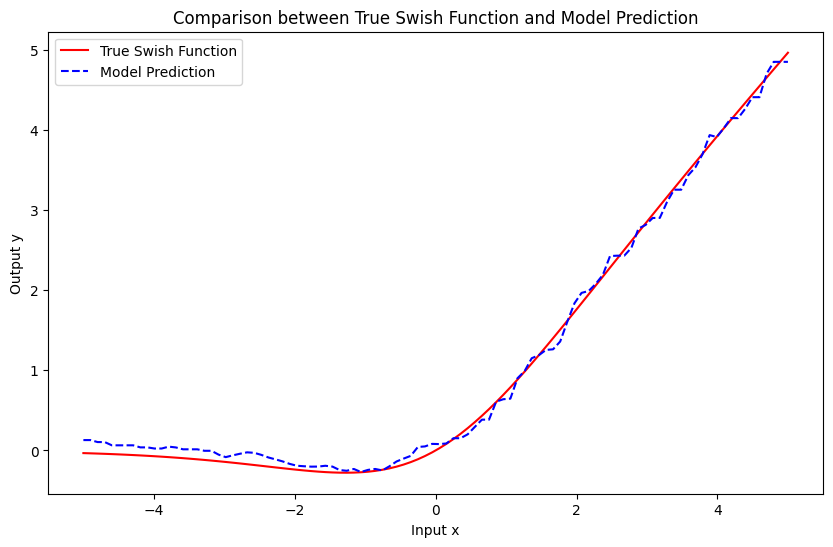

In [23]:
import matplotlib.pyplot as plt

# 모델 예측값 계산
with torch.no_grad():  # Gradient 계산이 필요 없음
    y_pred = model(x_train).squeeze()

# 실제 Swish 함수 값
y_true = swish_function(x_train).squeeze()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()
plt.show()

Mish 도전

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Mish 함수 구현
def mish_function(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

# PyTorch의 사용자 정의 그래디언트를 위한 spike function 구현
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# PyTorch spike function 호출
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# AMOSUnit 클래스 정의
class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons, num_params):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons

        # FS 파라미터 정의 (이제 학습 가능한 매개변수로)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

        # 학습 가능한 매개변수 추가
        self.linear = nn.Linear(input_dim, k_neurons)

        # 최종 출력을 위한 추가 선형 레이어
        self.final_linear = nn.Linear(k_neurons, 1)

    def forward(self, x):
        # 선형 변환 적용
        v = self.linear(x)

        # FS 스파이크 신경망을 위한 임시 출력 초기화
        temp_out = torch.zeros_like(v)

        # FS 스파이크 신경망 구현
        for t in range(len(self.T)):
            v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        # 최종 출력을 위해 추가된 선형 레이어 적용
        out = self.final_linear(temp_out)

        return out

# 모델 인스턴스화 및 초기 설정
input_dim = 1
k_neurons = 16  # 임의의 뉴런 수 선택
num_params = 16  # 임의의 파라미터 수 선택
model = AMOSUnit(input_dim, k_neurons, num_params)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 데이터
x_train = torch.linspace(-10, 10, steps=1000).unsqueeze(1)  # 입력
y_train = mish_function(x_train)  # 목표값 (실제 Mish 함수 값)

torch.autograd.set_detect_anomaly(True)

# 훈련 루프
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # 그래디언트 초기화
    y_pred = model(x_train)  # 순전파
    loss = criterion(y_pred, y_train)  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    if epoch % 1000 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# 최종 손실 출력
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 10.793375015258789
Epoch 1001/10000, Loss: 0.10025116801261902
Epoch 2001/10000, Loss: 0.040102072060108185
Epoch 3001/10000, Loss: 0.017018062993884087
Epoch 4001/10000, Loss: 0.006493214517831802
Epoch 5001/10000, Loss: 0.003967077471315861
Epoch 6001/10000, Loss: 0.0038365789223462343
Epoch 7001/10000, Loss: 0.0017502199625596404
Epoch 8001/10000, Loss: 0.004006318282335997
Epoch 9001/10000, Loss: 0.002468396443873644
Final Loss: 0.0019249062752351165


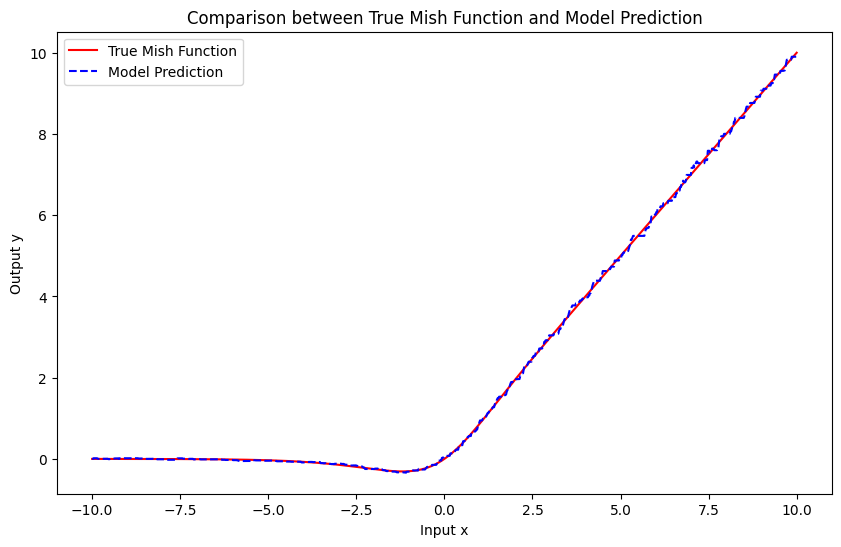

In [2]:
import matplotlib.pyplot as plt

# 모델 예측값 계산
with torch.no_grad():  # Gradient 계산이 필요 없음
    y_pred = model(x_train).squeeze()

# 실제 Mish 함수 값
y_true = mish_function(x_train).squeeze()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Mish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Mish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()
plt.show()

PReLU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# PReLU 함수 구현
def prelu_function(x, alpha=0.25):
    return torch.where(x > 0, x, x * alpha)

# PyTorch의 사용자 정의 그래디언트를 위한 spike function 구현
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# PyTorch spike function 호출
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# AMOSUnit 클래스 정의
class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons, num_params):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons

        # FS 파라미터 정의 (이제 학습 가능한 매개변수로)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

        # 학습 가능한 매개변수 추가
        self.linear = nn.Linear(input_dim, k_neurons)

        # 최종 출력을 위한 추가 선형 레이어
        self.final_linear = nn.Linear(k_neurons, 1)

    def forward(self, x):
        # 선형 변환 적용
        v = self.linear(x)

        # FS 스파이크 신경망을 위한 임시 출력 초기화
        temp_out = torch.zeros_like(v)

        # FS 스파이크 신경망 구현
        for t in range(len(self.T)):
            v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        # 최종 출력을 위해 추가된 선형 레이어 적용
        out = self.final_linear(temp_out)

        return out

# 모델 인스턴스화 및 초기 설정
input_dim = 1
k_neurons = 16  # 임의의 뉴런 수 선택
num_params = 16  # 임의의 파라미터 수 선택
model = AMOSUnit(input_dim, k_neurons, num_params)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 데이터
alpha_value = 0.25  # PReLU의 α 값, 모델에 의해 학습될 필요가 있는 값입니다.
x_train = torch.linspace(-10, 10, steps=1000).unsqueeze(1)  # 입력
y_train = prelu_function(x_train, alpha=alpha_value)  # 목표값 (실제 PReLU 함수 값)

torch.autograd.set_detect_anomaly(True)

# 훈련 루프
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # 그래디언트 초기화
    y_pred = model(x_train)  # 순전파
    loss = criterion(y_pred, y_train)  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    if epoch % 1000 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# 최종 손실 출력
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 33.80096435546875
Epoch 1001/10000, Loss: 0.047238580882549286
Epoch 2001/10000, Loss: 0.025626644492149353
Epoch 3001/10000, Loss: 0.017404824495315552
Epoch 4001/10000, Loss: 0.015388520434498787
Epoch 5001/10000, Loss: 0.00952918641269207
Epoch 6001/10000, Loss: 0.006196318194270134
Epoch 7001/10000, Loss: 0.004336345940828323
Epoch 8001/10000, Loss: 0.0033201570622622967
Epoch 9001/10000, Loss: 0.0024839243851602077
Final Loss: 0.0008831547456793487


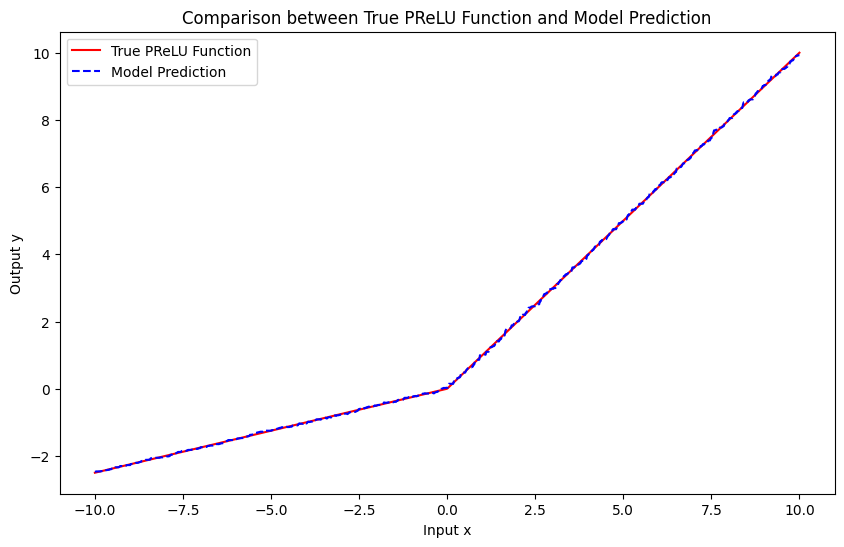

In [2]:
import matplotlib.pyplot as plt

# 모델 예측값 계산
with torch.no_grad():  # Gradient 계산이 필요 없음
    y_pred = model(x_train).squeeze()

# 실제 Mish 함수 값
y_true = prelu_function(x_train).squeeze()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True PReLU Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True PReLU Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()
plt.show()

Softplus

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# PReLU 함수 구현
def softplus_function(x):
    return torch.log(1 + torch.exp(x))

# PyTorch의 사용자 정의 그래디언트를 위한 spike function 구현
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# PyTorch spike function 호출
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# AMOSUnit 클래스 정의
class AMOSUnit(nn.Module):
    def __init__(self, input_dim, k_neurons, num_params):
        super(AMOSUnit, self).__init__()
        self.k_neurons = k_neurons

        # FS 파라미터 정의 (이제 학습 가능한 매개변수로)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

        # 학습 가능한 매개변수 추가
        self.linear = nn.Linear(input_dim, k_neurons)

        # 최종 출력을 위한 추가 선형 레이어
        self.final_linear = nn.Linear(k_neurons, 1)

    def forward(self, x):
        # 선형 변환 적용
        v = self.linear(x)

        # FS 스파이크 신경망을 위한 임시 출력 초기화
        temp_out = torch.zeros_like(v)

        # FS 스파이크 신경망 구현
        for t in range(len(self.T)):
            v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        # 최종 출력을 위해 추가된 선형 레이어 적용
        out = self.final_linear(temp_out)

        return out

# 모델 인스턴스화 및 초기 설정
input_dim = 1
k_neurons = 16  # 임의의 뉴런 수 선택
num_params = 16  # 임의의 파라미터 수 선택
model = AMOSUnit(input_dim, k_neurons, num_params)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 데이터
x_train = torch.linspace(-10, 10, steps=1000).unsqueeze(1)  # 입력
y_train = softplus_function(x_train)  # 목표값 (실제 Softplus 함수 값)

torch.autograd.set_detect_anomaly(True)

# 훈련 루프
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # 그래디언트 초기화
    y_pred = model(x_train)  # 순전파
    loss = criterion(y_pred, y_train)  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    if epoch % 1000 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# 최종 손실 출력
print(f'Final Loss: {loss.item()}')

Epoch 1/10000, Loss: 4.078455448150635
Epoch 1001/10000, Loss: 0.03644606098532677
Epoch 2001/10000, Loss: 0.01093063224107027
Epoch 3001/10000, Loss: 0.008429039269685745
Epoch 4001/10000, Loss: 0.004568331874907017
Epoch 5001/10000, Loss: 0.00334340101107955
Epoch 6001/10000, Loss: 0.0032802256755530834
Epoch 7001/10000, Loss: 0.00161116907838732
Epoch 8001/10000, Loss: 0.0009631903376430273
Epoch 9001/10000, Loss: 0.0005196108249947429
Final Loss: 0.0003269792068749666


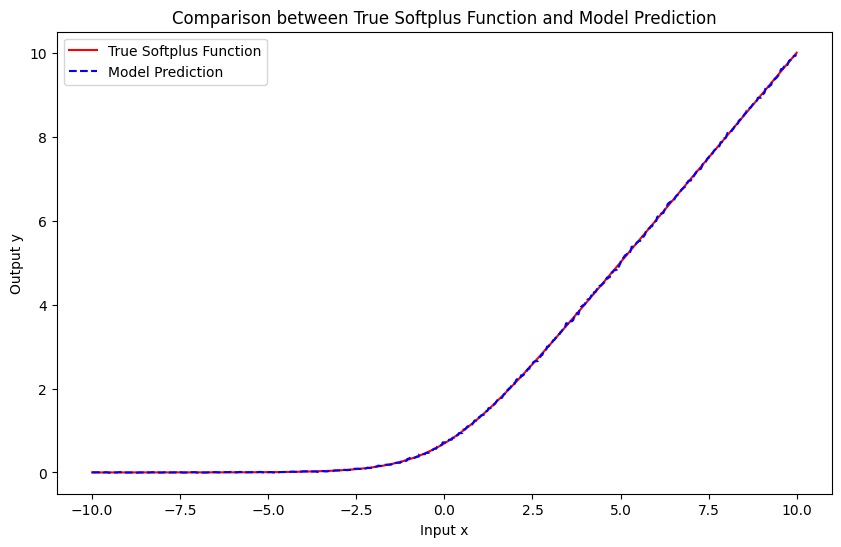

In [6]:
import matplotlib.pyplot as plt

# 모델 예측값 계산
with torch.no_grad():  # Gradient 계산이 필요 없음
    y_pred = model(x_train).squeeze()

# 실제 Mish 함수 값
y_true = softplus_function(x_train).squeeze()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()
plt.show()